# Alternating direction algorithms for l1 problems in compressive sensing

We provide a port of [YALL1 basic](http://yall1.blogs.rice.edu/) package. This is built on top of JAX and can be used to solve the following $\ell_1$ minimization problems.

The basis pursuit problem
$$
\tag{BP}
{\min}_{x} \| W x\|_{w,1} \; \text{s.t.} \, A x = b
$$

The L1/L2 minimization or basis pursuit denoising problem
$$
\tag{L1/L2}
{\min}_{x} \| W x\|_{w,1} + \frac{1}{2\rho}\| A x - b \|_2^2 
$$

The L1 minimization problem with L2 constraints
$$
\tag{L1/L2con}
{\min}_{x} \| W x\|_{w,1} \; \text{s.t.} \, \| A x - b \|_2 \leq \delta
$$

We also support corresponding non-negative counter-parts.

The nonnegative basis pursuit problem
$$
\tag{BP+}
{\min}_{x} \| W x\|_{w,1} \; \text{s.t.} \, A x = b \, \, \text{and} \, x \succeq 0
$$

The nonnegative L1/L2 minimization or basis pursuit denoising problem
$$
\tag{L1/L2+}
{\min}_{x} \| W x\|_{w,1} + \frac{1}{2\rho}\| A x - b \|_2^2  \; \text{s.t.} \, x \succeq 0
$$

The nonnegative L1 minimization problem with L2 constraints
$$
\tag{L1/L2con+}
{\min}_{x} \| W x\|_{w,1} \; \text{s.t.} \, \| A x - b \|_2 \leq \delta \, \, \text{and} \, x \succeq 0
$$


In the above, $W$ is a sparsifying basis s.t. $Wx = \alpha$ is a sparse representation of $x$ in $W$ given by 
$\alpha = W^T x$. For simple examples, we can assume $W=I$ is the identity basis.

The $\| \cdot \|_{w,1}$ is the weighted L1 (semi-) norm defined as

$$
\|x \|_{w,1} = \sum_{i=1}^n w_i |x_i| 
$$

for a  given non-negative weight vector $w$. In the simplest case, we assume $w=1$ reducing it to the famous $\ell_1$ norm.

Import relevant libraries

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
from jax import jit, grad, vmap
norm = jnp.linalg.norm

In [2]:
import cr.sparse as crs
import cr.sparse.dict as crdict
import cr.sparse.data as crdata
import cr.sparse.lop as lop
from cr.sparse.cvx.adm import yall1

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Setup a problem with a random sensing matrix with orthonormal rows

In [4]:
N = 1000
M = 300
K = 50

In [5]:
key = random.PRNGKey(0)
key1, key2, key3, key4 = random.split(key, 4)

In [6]:
A = crdict.random_orthonormal_rows(key1, M, N)

In [7]:
crs.has_orthogonal_rows(A)

DeviceArray(True, dtype=bool)

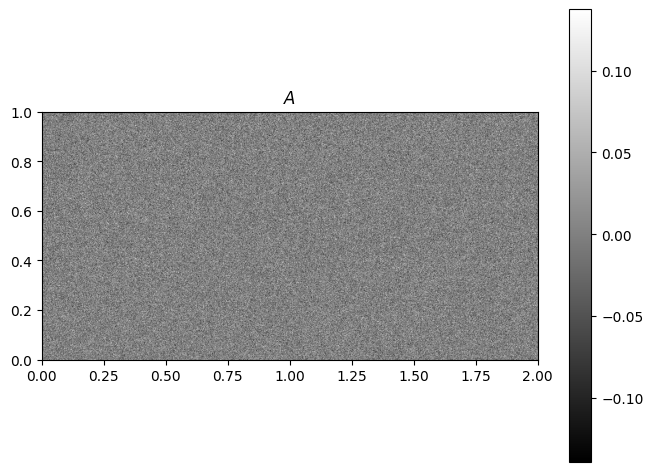

In [8]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(A, extent=[0, 2, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'$A$');

In [9]:
x, omega = crdata.sparse_normal_representations(key2, N, K, 1)
x = jnp.squeeze(x)

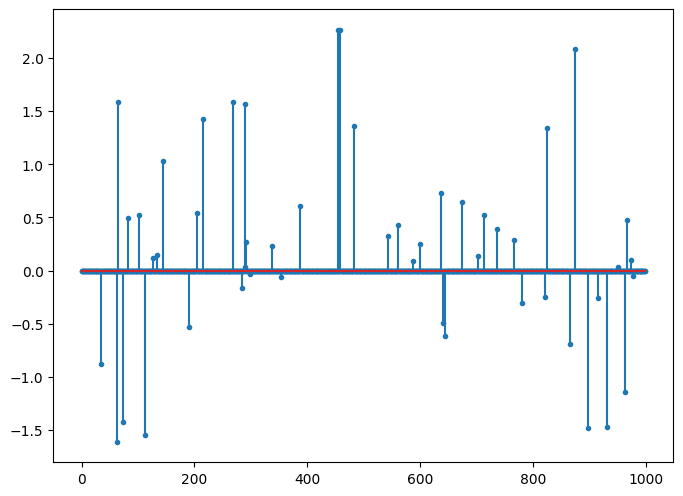

In [10]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(x, markerfmt='.');

In [11]:
# Convert A into a linear operator
A = lop.matrix(A)

## Standard sparse recovery problems for compressive sensing

### Basis pursuit

The simple form of basis pursuit problem is:

$$
{\min}_{x} \| x\|_{1} \; \text{s.t.} \, A x = b
$$

In [12]:
# Compute the measurements
b0 = A.times(x)

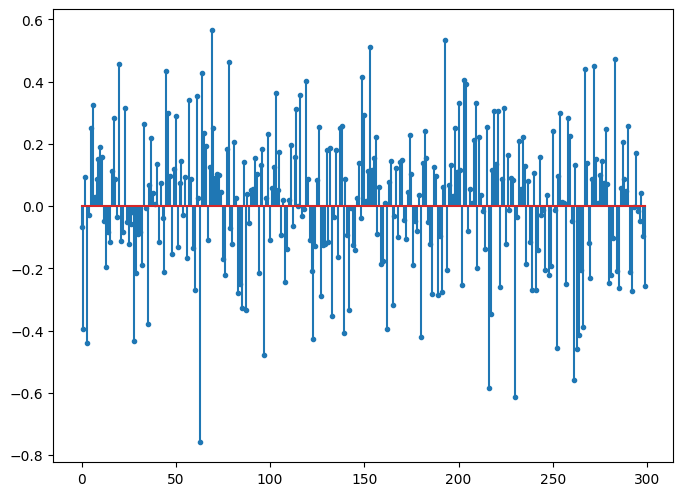

In [13]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(b0, markerfmt='.');

In [14]:
sol = yall1.solve(A, b0)

In [15]:
int(sol.iterations), int(sol.n_times), int(sol.n_trans)

(30, 61, 32)

In [16]:
norm(sol.x-x)/norm(x)

DeviceArray(0.01208655, dtype=float64)

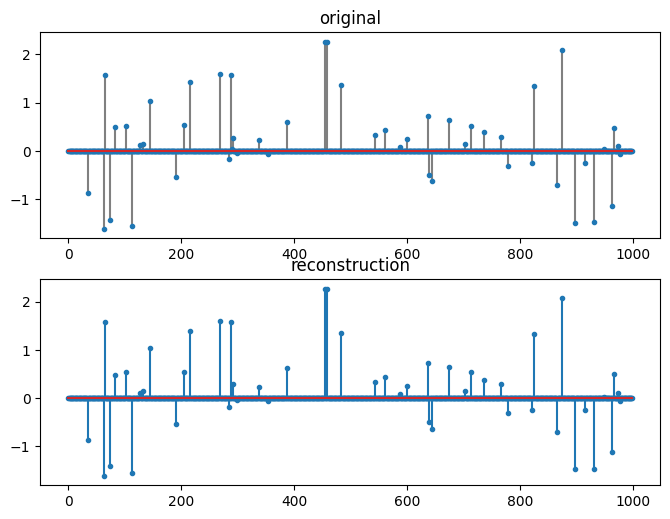

In [17]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('original')
plt.stem(x, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(sol.x, markerfmt='.');
plt.title('reconstruction');

In [18]:
%timeit yall1.solve(A, b0).x.block_until_ready()

4.77 ms ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Basis pursuit denoising

The simple form of L1-L2 unconstrained minimization or basis pursuit denoising is:
$$
{\min}_{x} \| x\|_{1} + \frac{1}{2\rho}\| A x - b \|_2^2
$$

In [19]:
sigma = 0.01
noise = sigma * random.normal(key3, (M,))

In [20]:
crs.snr(b0, noise)

DeviceArray(27.34386008, dtype=float64)

In [21]:
b = b0 + noise

In [22]:
sol = yall1.solve(A, b, rho=0.01)

In [23]:
int(sol.iterations), int(sol.n_times), int(sol.n_trans)

(28, 57, 30)

In [24]:
norm(sol.x-x)/norm(x)

DeviceArray(0.05690205, dtype=float64)

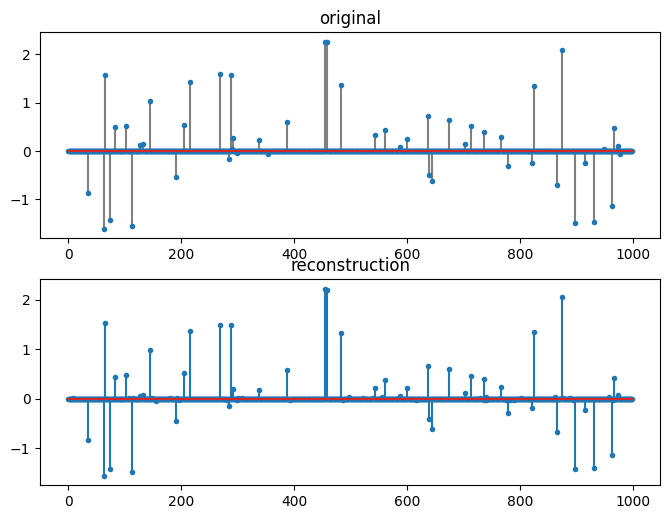

In [25]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('original')
plt.stem(x, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(sol.x, markerfmt='.');
plt.title('reconstruction');

In [26]:
%timeit yall1.solve(A, b, rho=0.01).x.block_until_ready()

4.47 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Basis pursuit with inequality constraints

The simple form of L1 minimization with L2 constraints or basis pursuit with inequality constraints is:
$$
{\min}_{x} \| x\|_{1} \; \text{s.t.} \, \| A x - b \|_2 \leq \delta
$$

In [27]:
delta = float(norm(noise))
delta

0.16467458902598495

In [28]:
sol = yall1.solve(A, b, delta=delta)

In [29]:
int(sol.iterations), int(sol.n_times), int(sol.n_trans)

(26, 53, 28)

In [30]:
norm(sol.x-x)/norm(x)

DeviceArray(0.05584753, dtype=float64)

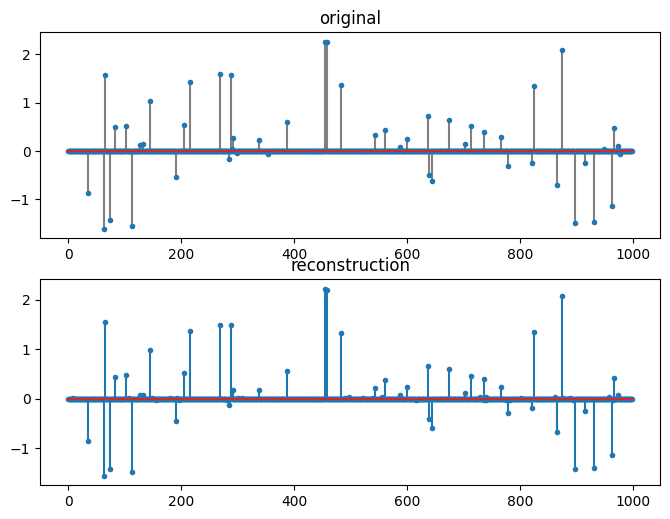

In [31]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('original')
plt.stem(x, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(sol.x, markerfmt='.');
plt.title('reconstruction');

In [32]:
%timeit yall1.solve(A, b, delta=delta).x.block_until_ready()

4.65 ms ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Non-negative counterparts

In this case, the signal $x$ with the sparse representation $\alpha = W x$ has only non-negative entries. i.e. if an entry in $x$ is non-zero, it is positive. This is typical for images.

Let us construct a sparse representation with non-negative entries.

In [33]:
xp = jnp.abs(x)

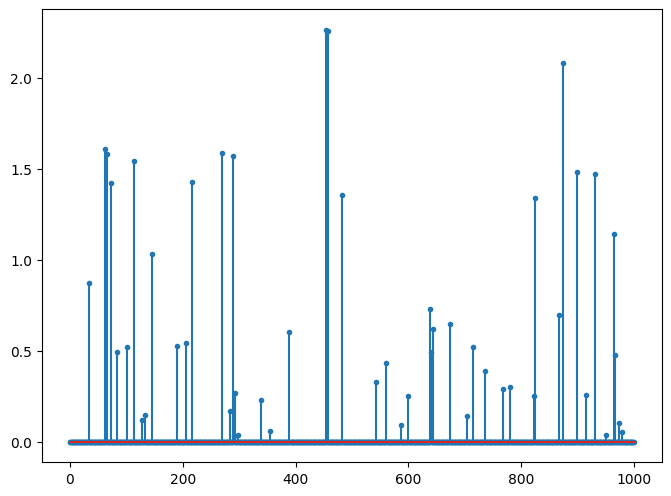

In [34]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(xp, markerfmt='.');

### Non-negative basis pursuit

The simple form of basis pursuit for non-negative $x$ is:
$$
{\min}_{x} \| x\|_{1} \; \text{s.t.} \, A x = b \, \, \text{and} \, x \succeq 0
$$

In [35]:
b0p = A.times(xp)

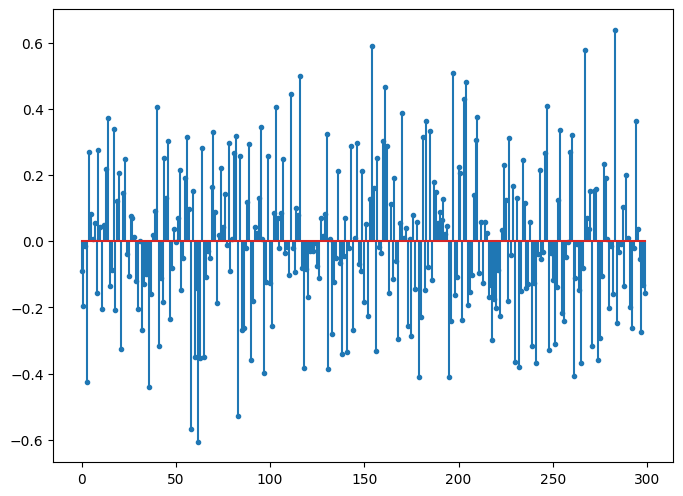

In [36]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(b0p, markerfmt='.');

In [37]:
sol = yall1.solve(A, b0p, nonneg=True)

In [38]:
int(sol.iterations), int(sol.n_times), int(sol.n_trans)

(36, 73, 38)

In [39]:
norm(sol.x-xp)/norm(xp)

DeviceArray(0.01095682, dtype=float64)

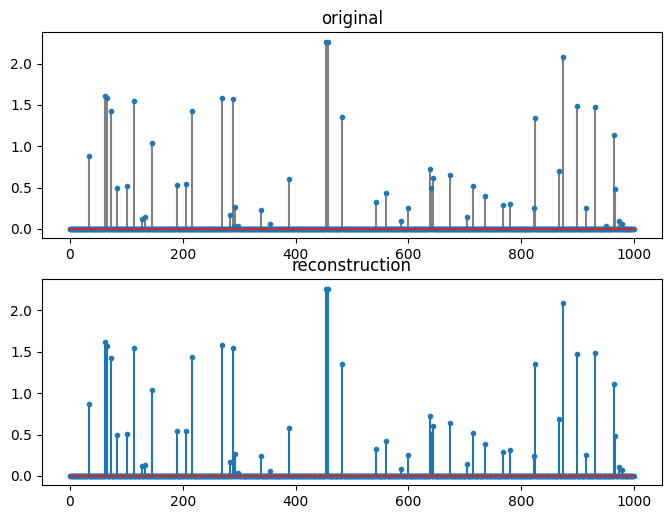

In [40]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('original')
plt.stem(xp, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(sol.x, markerfmt='.');
plt.title('reconstruction');

In [41]:
%timeit yall1.solve(A, b0p, nonneg=True).x.block_until_ready()

5.27 ms ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Non-negative basis pursuit denoising

The simple form of L1-L2 unconstrained minimization with non-negative $x$ is:
$$
{\min}_{x} \| x\|_{1} + \frac{1}{2\rho}\| A x - b \|_2^2  \; \text{s.t.} \, x \succeq 0
$$

In [42]:
crs.snr(b0p, noise)

DeviceArray(27.43652935, dtype=float64)

In [43]:
bp = b0p + noise

In [44]:
sol = yall1.solve(A, bp, nonneg=True, rho=0.01)

In [45]:
int(sol.iterations), int(sol.n_times), int(sol.n_trans)

(28, 57, 30)

In [46]:
norm(sol.x-xp)/norm(xp)

DeviceArray(0.04551954, dtype=float64)

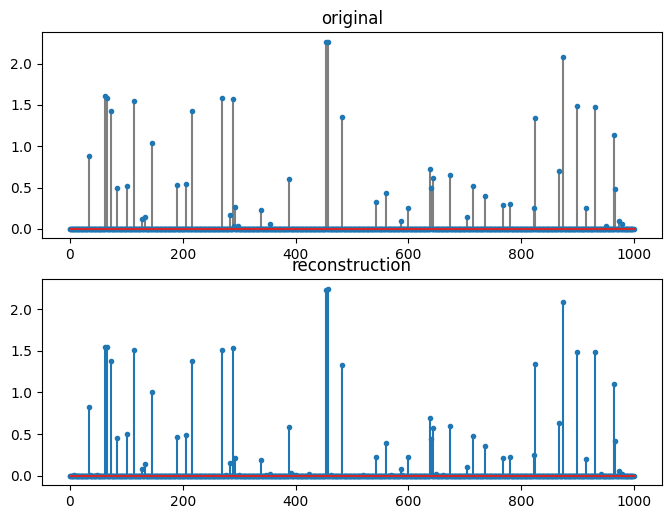

In [47]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('original')
plt.stem(xp, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(sol.x, markerfmt='.');
plt.title('reconstruction');

In [48]:
%timeit yall1.solve(A, bp, nonneg=True, rho=0.01).x.block_until_ready()

4.58 ms ± 85.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Non-negative basis pursuit with inequality constraints

$$
{\min}_{x} \| x\|_{1} \; \text{s.t.} \, \| A x - b \|_2 \leq \delta \, \, \text{and} \, x \succeq 0
$$

In [49]:
sol = yall1.solve(A, bp, delta=delta)

In [50]:
int(sol.iterations), int(sol.n_times), int(sol.n_trans)

(24, 49, 26)

In [51]:
norm(sol.x-xp)/norm(xp)

DeviceArray(0.05724303, dtype=float64)

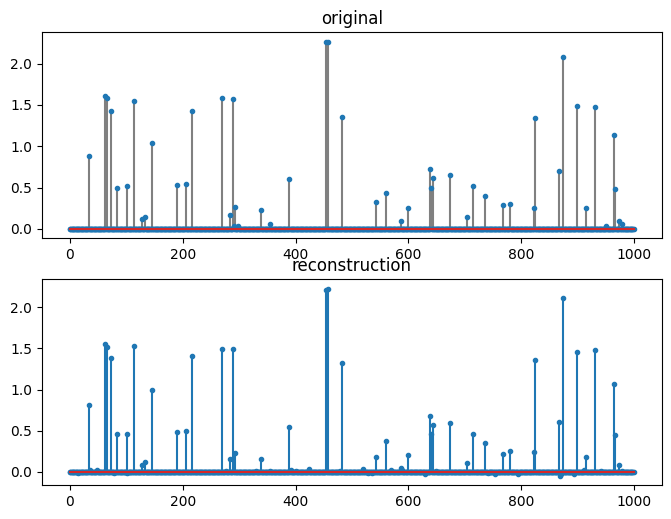

In [52]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('original')
plt.stem(xp, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(sol.x, markerfmt='.');
plt.title('reconstruction');

In [53]:
%timeit yall1.solve(A, bp, delta=delta).x.block_until_ready()

4.35 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
